# Ladder Sampling of 2D Ising Model

## Hamiltonian
\begin{align}
H = -\sum_{<ij>}J_{ij}S_{i} S_{j} - \sum_{i} h_{i}S_{i}，
\end{align}
where $N$ is the number of spins and we assume $J_{ij} = J$.

## 1. Free bounday condition

### Partition function of a tree：

  O     O     #(7)     O      O 
  O    #(8)   X(1)   #(16)    O 
 #(9)  X(2)   X(3)   X(4)   #(15)
  O    #(10)  X(5)   #(14)    O
  O    #(11)  X(6)   #(13)    O
  O     O     #(12)    O      O

### $Z_{1}$:
\begin{align}
Z_{1}(\theta_{1}) &= \int_{-\pi}^{\pi}d\theta_{2}\cdots d\theta_{N}\exp{[\beta J(\cos{(\theta_{1} - \theta_{2})} + \cos{(\theta_{2} - \theta_{3})} + \cdots + \cos{(\theta_{N-1} - \theta_{N})})]}\\
&=(2\pi)^{N-2}[I_{0}(\beta J)]^{N-2}\int_{-\pi}^{\pi}d\theta_{2}\exp{[\beta J\cos{(\theta_{1}-\theta_{2}})]}, 
\end{align}
then we get
\begin{align}
P(\theta_{1}) &= \frac{Z_{1}(\theta_{1})}{Z} = \frac{\int_{-\pi}^{\pi}d\theta\exp{[\beta J\cos{(\theta_{1}-\theta})]}}{(2\pi)^{2} I_{0}(\beta J)}\\
&=\frac{1}{2\pi}.
\end{align}

### So the perfect sampling of the 1D XY model (free boundary condition) is as follows,
#### 1. Sample $\theta_{1}$ from 
\begin{align}
P(\theta_{1}) = \frac{1}{2\pi},
\end{align}

#### 2. Sample $\theta_{k}$ from the following distribution recursively:
\begin{align}
P(\theta_{k}|\theta_{k-1}, \cdots, \theta_{1}) = \frac{\exp{[\beta J\cos{(\theta_{k-1}-\theta_{k})}]}}{2\pi I_{0}(\beta J)}.
\end{align}

----

### Ladder Sampling of 2D Ising model

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange
import time

In [6]:
from math import cos, exp, pi
from scipy.integrate import quad
from scipy.special import iv

In [160]:
class ISING_2D_ladder:
    
    def __init__(self, j=1, beta=1, h=1, dims=(10, 10), nc=5):
        """
        Args:
            nc: (int) size of the cluster.
        """
        self.j = j
        self.beta = beta
        self.h = h
        self.dims = dims
        self.grids = (-1) ** np.reshape(np.random.binomial(1, 1/2, dims[0]*dims[1]), dims)
        self.nc = nc
        
    def neibor_get(self, id_grid):
        height, width = self.dims
        x_index, y_index = id_grid
        l_neibor = ((x_index - 1) % width, y_index)
        r_neibor = ((x_index + 1) % width, y_index)
        u_neibor = (x_index, (y_index - 1) % height)
        d_neibor = (x_index, (y_index + 1) % height)           
        ur_neibor = ((x_index + 1) % width, (y_index + 1) % height)
        dl_neibor = ((x_index - 1) % width, (y_index - 1) % height)
        
        return {'l': l_neibor, 
                'r': r_neibor, 
                'u': u_neibor, 
                'd': d_neibor, 
                'ur': ur_neibor, 
                'dl': dl_neibor}
    
    def message_on_node(self, id_ud, neibors_ud):
        def energy_get(spins_ud, neibors_ud):
            energy = 0
            spin_u, spin_d = spins_ud
            neibors_u, neibors_d = neibors_ud
            for id_neibor in neibors_u:
                energy += -self.j * spin_u * self.grids[id_neibor[0]][id_neibor[1]]
            energy += -self.j * self.h * spin_u
            for id_neibor in neibors_d:
                energy += -self.j * spin_d * self.grids[id_neibor[0]][id_neibor[1]]
            energy += -self.j * self.h * spin_d
            energy += -self.j * spin_u * spin_d
            return energy
        energy_uu = energy_get((1, 1), neibors_ud)
        energy_ud = energy_get((1, -1), neibors_ud)
        energy_du = energy_get((-1, 1), neibors_ud)
        energy_dd = energy_get((-1, -1), neibors_ud)
        #message = np.array([np.exp(-self.beta * energy_uu), np.exp(-self.beta * energy_ud),
        #                    np.exp(-self.beta * energy_du), np.exp(-self.beta * energy_dd)])
        message = np.array([np.exp(-self.beta * (-energy_dd)), 
                            np.exp(-self.beta * (energy_ud - energy_uu - energy_dd)),
                            np.exp(-self.beta * (energy_du - energy_uu - energy_dd)), 
                            np.exp(-self.beta * (-energy_uu))])
        
        message_norm = message / np.sum(message)
        return message_norm
    
    def message_on_edge(self):
        """
        Args:
            edge: (tuple) (node_start, node_end)
            
        Returns:
            message: (np.array) 4x4 matrix
        """
        def message_compute_one_row(spins_left, spins_right_list):
            """
            Args:
                spins_left: (tuple)
                spins_right_list: (list) 
                
            Returns:
                left_right_row: (np.array)
            """
            spin_lu, spin_ld = spins_left
            left_right_list = []
            for spins_right in spins_right_list:
                energy_total = 0
                spin_ru, spin_rd = spins_right
                energy_total += -self.j * spin_lu * spin_ru
                energy_total += -self.j * spin_ld * spin_rd
                energy_total += -self.j * spin_ld * spin_ru
                left_right_list.append(np.exp(-self.beta * energy_total))
            return np.array(left_right_list)
        
        spins_left_list = spins_right_list = [(1, 1), (1, -1), (-1, 1), (-1, -1)]
        message_list = []
        for spins_left in spins_left_list:
            message_list.append(message_compute_one_row(spins_left, spins_right_list))
        message = np.array(message_list)
        message = message / message[0][0]
        return message    
    
    def loop_sampling(self, id_height):
        id_end = np.random.randint(self.dims[1])
        id_start = (id_end + 1) % self.dims[1]
        path_to_left = [id_start, id_end] 
        path_to_right = [(id_start + i) % self.dims[1] for i in range(self.dims[1])]
        assert path_to_right[-1] == id_end, "Path to right is not right!"
        ### get the message on the edge which is shared by all the other edge
        message_edge = self.message_on_edge()
        message_on_node = []
        dict_filter = lambda old_dict, keys_set: [old_dict[key] for key in keys_set]
        for id_width in range(self.dims[1]):
            id_u, id_d = (id_height, id_width), ((id_height + 1) % self.dims[0], id_width)
            id_ud = (id_u, id_d)
            neibors_u = self.neibor_get(id_u)
            neibors_d = self.neibor_get(id_d)
            keys_u = ('u', 'ur')
            keys_d = ('d', 'dl')
            neibors_u = dict_filter(neibors_u, keys_u)
            neibors_d = dict_filter(neibors_d, keys_d)
            neibors_ud = (neibors_u, neibors_d)
            message_node = self.message_on_node(id_ud, neibors_ud)
            message_on_node.append(message_node)
        z_right = np.sqrt(message_on_node[id_start])
        z_left = np.sqrt(message_on_node[id_start])
        while id_start != id_end:
            id_start = (id_start + 1) % self.dims[1]
            z_right = np.matmul(z_right, message_edge)
            if id_start == id_end:
                z_right *= np.sqrt(message_on_node[id_start])
            else:
                z_right *= message_on_node[id_start]
        while id_start != id_end:
            id_start = (id_start - 1) % self.dims[1]
            z_left = np.matmul(z_left, message_edge)
            if id_start == id_end:
                z_left *= np.sqrt(message_on_node[id_start])
            else:
                z_left *= message_on_node[id_start]      
        z = z_left * z_right
        z_norm = z / np.sum(z)
        unif_random = np.random.uniform(0, 1)
        if unif_random < z_norm[0]:
            spin_start = np.array([1, 1])
        elif z_norm[0] <= unif_random < z_norm[0] + z_norm[1]:
            spin_start = np.array([1, -1])
        elif z_norm[0] + z_norm[1] <= unif_random < 1 - z_norm[-1]:
            spin_start = np.array([-1, 1])
        else:
            spin_start = np.array([-1, -1])
        self.grids[id_height][id_start] = spin_start[0]
        self.grids[(id_height+1)%self.dims[0]][id_start] = spin_start[1]
        return id_start
    
    def chain_sampling(self, id_height, id_start):
        stack = []
        id_end = (id_start - 1) % self.dims[1]
        id_start = (id_start + 1) % self.dims[1]
        dict_filter = lambda old_dict, keys_set: [old_dict[key] for key in keys_set]
        if self.dims[1] > 2:
            start_u = ((id_height + 1) % self.dims[0], id_start)
            start_d = (id_height % self.dims[0], id_start)
            neibors_u = self.neibor_get(start_u)
            neibors_d = self.neibor_get(start_d)
            keys_u = ('u', 'ur', 'l', 'dl')
            keys_d = ('l', 'd', 'dl')
            neibors_u = dict_filter(neibors_u, keys_u)
            neibors_d = dict_filter(neibors_d, keys_d)
        else:
            start_u = ((id_height + 1) % self.dims[0], id_start)
            start_d = (id_height % self.dims[0], id_start)
            neibors_u = self.neibor_get(start_u)
            neibors_d = self.neibor_get(start_d)
            keys_u = ('u', 'ur', 'l', 'dl', 'r')
            keys_d = ('l', 'd', 'dl', 'r')
            neibors_u = dict_filter(neibors_u, keys_u)
            neibors_d = dict_filter(neibors_d, keys_d)
        message_edge = self.message_on_edge()
        start_ud, neibors_ud = (start_u, start_d), (neibors_u, neibors_d)
        z_start = self.message_on_node(start_ud, neibors_ud)
        stack.append(z_start)
        while id_start != id_end:
            id_start = (id_start + 1) % self.dims[1]
            z_start = np.matmul(z_start, message_edge)
            if id_start == id_end:
                start_u = ((id_height + 1) % self.dims[1], id_start)
                start_d = (id_height % self.dims[1], id_start)
                neibors_u = self.neibor_get(start_u)
                neibors_d = self.neibor_get(start_d)
                keys_u = ('u', 'ur')
                keys_d = ('d', 'dl')
                neibors_u = dict_filter(neibors_u, keys_u)
                neibors_d = dict_filter(neibors_d, keys_d)
            else:
                start_u = ((id_height + 1) % self.dims[1], id_start)
                start_d = (id_height % self.dims[1], id_start)
                neibors_u = self.neibor_get(start_u)
                neibors_d = self.neibor_get(start_d)
                keys_u = ('u', 'ur', 'r')
                keys_d = ('d', 'dl', 'r', 'ur')
                neibors_u = dict_filter(neibors_u, keys_u)
                neibors_d = dict_filter(neibors_d, keys_d)
            start_ud, neibors_ud = (start_u, start_d), (neibors_u, neibors_d)
            node_message = self.message_on_node(start_ud, neibors_ud)
            z_start = z_start * node_message
            stack.append(z_start)
        z_start = stack.pop()
        z_start_norm = z_start / np.sum(z_start)
        unif_random = np.random.uniform(0, 1)
        if unif_random < z_start_norm[0]:
            spin_start = np.array([1, 1])
        elif z_start_norm[0] <= unif_random < z_start_norm[0] + z_start_norm[1]:
            spin_start = np.array([1, -1])
        elif z_start_norm[0] + z_start_norm[1] <= unif_random < 1 - z_start_norm[-1]:
            spin_start = np.array([-1, 1])
        else:
            spin_start = np.array([-1, -1])
        self.grids[id_height][id_start] = spin_start[0]
        self.grids[(id_height+1)%self.dims[0]][id_start] = spin_start[1]
        
        return stack, id_start
    
    def backtrack_sampling(self, id_height, id_start, stack):
        spins_list = []
        message_edge = self.message_on_edge()
        dict_filter = lambda old_dict, keys_set: [old_dict[key] for key in keys_set]
        while len(stack) != 0:
            id_start = (id_start - 1) % self.dims[1]   
            start_d = (id_height, id_start)
            start_u = ((id_height + 1) % self.dims[0], id_start)
            neibors_d = self.neibor_get(start_d)
            neibors_u = self.neibor_get(start_u)
            keys_u = ('u', 'ur', 'r')
            keys_d = ('ur', 'r', 'd', 'dl')
            neibors_u = dict_filter(neibors_u, keys_u)
            neibors_d = dict_filter(neibors_d, keys_d)
            start_ud = (start_u, start_d)
            neibors_ud = (neibors_u, neibors_d)
            message_node = self.message_on_node(start_ud, neibors_ud)
            #z_start = np.matmul(message_node, message_edge)
            z_start = message_node * stack.pop()
            z_start_norm = z_start / np.sum(z_start)
            unif_random = np.random.uniform(0, 1)
            if unif_random < z_start_norm[0]:
                spin_start = np.array([1, 1])
            elif z_start_norm[0] <= unif_random < z_start_norm[0] + z_start_norm[1]:
                spin_start = np.array([1, -1])
            elif z_start_norm[0] + z_start_norm[1] <= unif_random < 1 - z_start_norm[-1]:
                spin_start = np.array([-1, 1])
            else:
                spin_start = np.array([-1, -1])
            self.grids[id_height][id_start] = spin_start[0]
            self.grids[(id_height+1)%self.dims[0]][id_start] = spin_start[1]
    
    def ladder_sampling(self, id_height):
        id_start = self.loop_sampling(id_height)
        stack, id_start = self.chain_sampling(id_height, id_start)
        self.backtrack_sampling(id_height, id_start, stack)
        
    def ladder_evolution(self):
        for i in range(self.dims[1]):
            self.ladder_sampling(i)
                     
    def tree_create(self):
        def neibor_search(id_grid, tree_list):
            height, width = id_grid
            neibors = []
            num_shared = 0
            if height < self.dims[0] - 1:
                if (height + 1, width) not in tree_list:
                    neibors.append((height + 1, width))
                else:
                    num_shared += 1
            if height > 0:
                if (height - 1, width) not in tree_list:
                    neibors.append((height - 1, width))
                else:
                    num_shared += 1
            if width < self.dims[1] - 1:
                if (height, width + 1) not in tree_list:
                    neibors.append((height, width + 1))
                else:
                    num_shared += 1
            if width > 0:
                if (height, width - 1) not in tree_list:
                    neibors.append((height, width - 1))
                else:
                    num_shared += 1
                    
            return neibors, num_shared
        
        tree_list = []
        stack = []
        height, width = self.dims
        height_rand = np.random.randint(0, height)
        width_rand = np.random.randint(0, width)
        id_start = (height_rand, width_rand)
        stack.append(id_start)
        while len(tree_list) < self.nc:
            node_leaf = stack.pop()
            if node_leaf in tree_list:
                tree_list.pop()
                continue
            neibors_leaf, num_shared = neibor_search(node_leaf, tree_list)
            if len(neibors_leaf) >= 1 and num_shared < 2:
                tree_list.append(node_leaf)
                stack.append(node_leaf)
                stack.extend(neibors_leaf)
            else:
                if node_leaf == tree_list[-1]:
                    tree_list.pop()
        return tree_list
    
    def tree_viz(self):
        zero_one_row = 'o' * self.dims[1] + '\n'
        zeros_grids = zero_one_row * self.dims[0]
        for node in self.tree_list:
            node_pos = node[0] * (self.dims[1] + 1) + node[1]
            zeros_grids = zeros_grids[:node_pos] + 'x' + zeros_grids[node_pos+1:]
        print(zeros_grids)
        
    def spin_viz(self, figsize=(10, 10), save=False, folder_name=None):
        fig = plt.figure(figsize=figsize)
        x, y = np.meshgrid(np.arange(0, self.dims[0]), np.arange(0, self.dims[1]))
        u = np.cos(self.grids*np.pi/2)
        v = np.sin(self.grids*np.pi/2)
        q = plt.quiver(x, y, u, v)
        plt.axis('off')
        plt.title('T={:.3f}, spins={}'.format(1/self.beta, self.dims), fontsize=20)
        if save and step is not None:
            plt.savefig(f'./{folder_name}/config_plot_step_{step}.pdf', dpi=100)
            plt.close(fig)
            
    def energy_compute_grids(self):
        energy_total = 0
        for i in range(self.dims[0]):
            for j in range(self.dims[1]):
                id_neibors_dict = self.neibor_get((i, j))
                id_neibors = id_neibors_dict.values()
                energy_ij = 0
                for ij in id_neibors:
                    energy_ij = -self.j * self.grids[ij[0]][ij[1]] * self.grids[i][j]
                energy_total += energy_ij
                ### compute the energy of external field
                energy_total += -self.h * self.grids[i][j]
        energy_per_spin = energy_total / (self.dims[0] * self.dims[1])
        return energy_per_spin
    
    def magnet_grids(self):
        magnet_x, magnet_y = 0, 0
        for i in range(self.length):
            magnet_x += np.sin(self.grids[i])
            magnet_y += np.cos(self.grids[i])
        return magnet_x, magnet_y

### Low Temperature (External Field h = 0)

In [179]:
ising_2d = ISING_2D_ladder(beta=200, j=1, h=0, dims=(10, 10), nc=5)

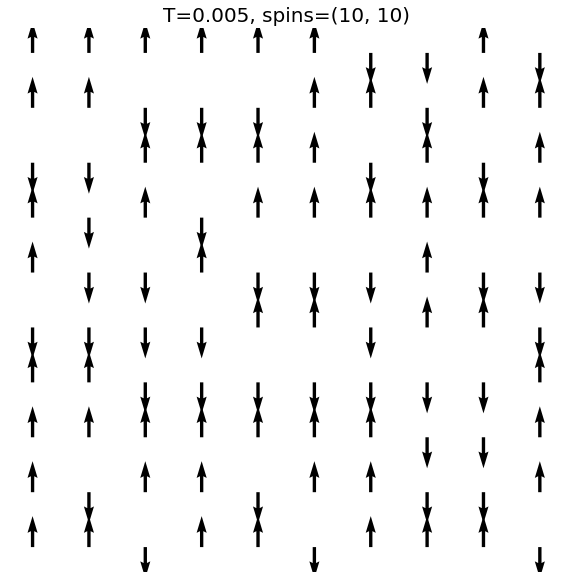

In [180]:
ising_2d.spin_viz()

In [ ]:
ising_2d.ladder_evolution()

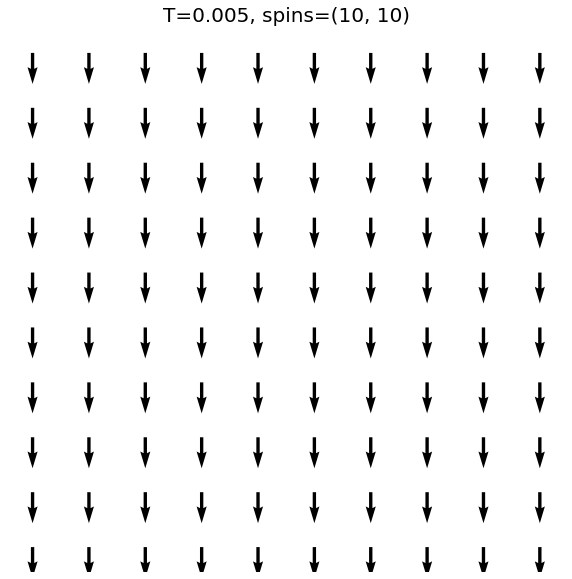

In [182]:
ising_2d.spin_viz()

In [183]:
print(f"The energy of the system is: {ising_2d.energy_compute_grids():.3f}.")

The energy of the system is: -1.000.


------
### High Temperature (External Field = 0)

In [185]:
ising_2d = ISING_2D_ladder(beta=1, j=1, h=0, dims=(10, 10))

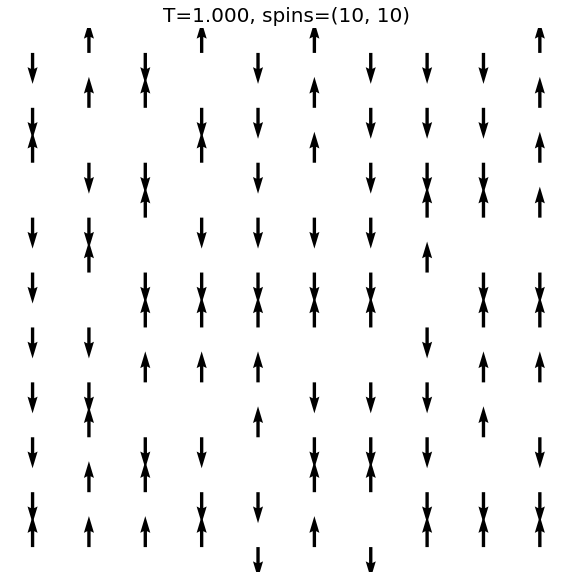

In [186]:
ising_2d.spin_viz()

In [188]:
ising_2d.ladder_evolution()

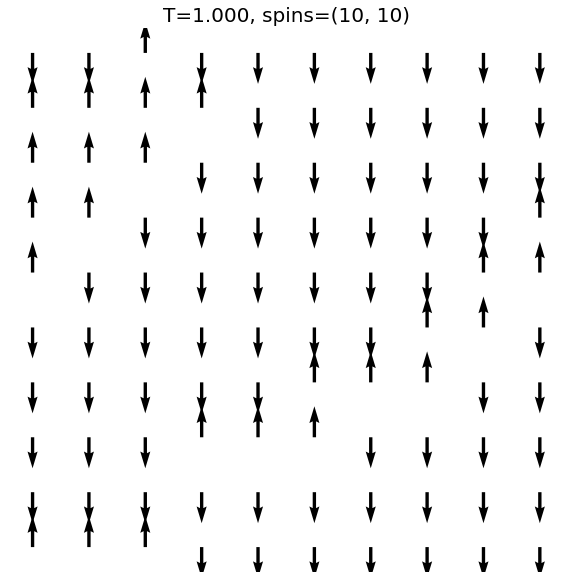

In [189]:
ising_2d.spin_viz()

In [190]:
print(f"The energy of the system is: {ising_2d.energy_compute_grids():.3f}.")

The energy of the system is: -0.640.


-----
### External field h = 0

In [192]:
temp_list = [0.1 + 0.5 * i for i in range(10)]
beta_list = [1 / temp for temp in temp_list]
dims = (5, 5)

In [194]:
mean_sampling_list = []
std_sampling_list = []
for i in trange(10):
    beta = beta_list[i]
    ising_2d = ISING_2D_ladder(beta=beta, h=0, dims=dims)
    ### Get to the equilibrium state
    for _ in trange(10000):
        ising_2d.ladder_evolution()
    ### Sampling stage
    energy_list = []
    for i in trange(10000):
        ising_2d.ladder_evolution()
        energy_list.append(ising_2d.energy_compute_grids())
    print("iterations are done!")
    mean_sampling_list.append(np.mean(energy_list))
    std_sampling_list.append(np.std(energy_list))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


In [195]:
mean_sampling_list

[-1.0,
 -0.999984,
 -0.9996320000000002,
 -0.995168,
 -0.978032,
 -0.93984,
 -0.8757279999999998,
 -0.7792479999999999,
 -0.6385599999999999,
 -0.47884799999999994]

In [196]:
std_sampling_list

[0.0,
 0.0015999199979999,
 0.0076645010274642164,
 0.028119953342777795,
 0.06210158593788085,
 0.10337337374778865,
 0.1517081079441702,
 0.20489547212176262,
 0.2601227525611706,
 0.29715442600775777]

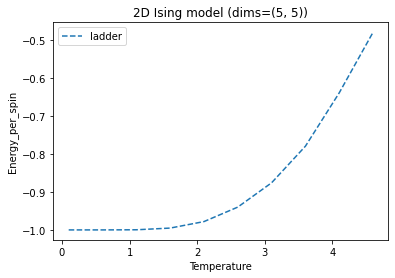

In [197]:
plt.plot(temp_list, mean_sampling_list, '--', label='ladder')
#plt.plot(energy_mean_list, 'o', label='metropolis')
plt.xlabel('Temperature')
plt.ylabel('Energy_per_spin')
plt.title('2D Ising model (dims=(5, 5))')
plt.legend()

In [198]:
beta_list = [0.05 * i for i in range(1, 11)]
temp_list = [1 / beta for beta in beta_list]
dims = (5, 5)

In [200]:
mean_sampling_list = []
std_sampling_list = []
for i in trange(10):
    beta = beta_list[i]
    ising_2d = ISING_2D_ladder(beta=beta, h=0, dims=dims)
    ### Get to the equilibrium state
    for _ in trange(10000):
        ising_2d.ladder_evolution()
    ### Sampling stage
    energy_list = []
    for i in trange(10000):
        ising_2d.ladder_evolution()
        energy_list.append(ising_2d.energy_compute_grids())
    print("iterations are done!")
    mean_sampling_list.append(np.mean(energy_list))
    std_sampling_list.append(np.std(energy_list))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


In [201]:
mean_sampling_list

[-0.008512,
 -0.04825599999999999,
 -0.13859200000000002,
 -0.36624,
 -0.681904,
 -0.8345600000000001,
 -0.9149280000000001,
 -0.95104,
 -0.970672,
 -0.981856]

In [202]:
std_sampling_list

[0.2007390989717748,
 0.2108808157799092,
 0.24190696049514573,
 0.29190591360916274,
 0.24924890126939375,
 0.17845875265730168,
 0.12459420057129465,
 0.09098416565534907,
 0.0712136813821614,
 0.05564238729601742]

In [204]:
energy_metropolis_list = [-0.051888,
                          -0.10681600000000001,
                          -0.187264,
                          -0.32660800000000006,
                          -0.548512,
                          -0.7941919999999999,
                          -0.8984639999999999,
                          -0.949824,
                          -0.9734879999999999,
                          -0.985568]

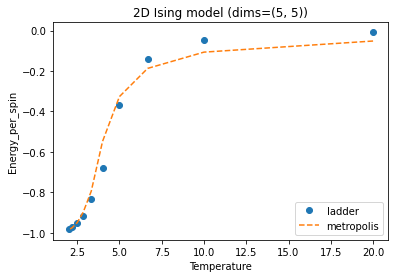

In [205]:
plt.plot(temp_list, mean_sampling_list, 'o', label='ladder')
plt.plot(temp_list, energy_metropolis_list, '--', label='metropolis')
plt.xlabel('Temperature')
plt.ylabel('Energy_per_spin')
plt.title('2D Ising model (dims=(5, 5))')
plt.legend()

---

In [206]:
beta_list = [0.05 * i for i in range(1, 11)]
temp_list = [1 / beta for beta in beta_list]
dims = (5, 5)

In [ ]:
mean_sampling_list = []
std_sampling_list = []
for i in trange(10):
    beta = beta_list[i]
    ising_2d = ISING_2D_ladder(beta=beta, h=0, dims=dims)
    ### Get to the equilibrium state
    for _ in trange(100000):
        ising_2d.ladder_evolution()
    ### Sampling stage
    energy_list = []
    for i in trange(100000):
        ising_2d.ladder_evolution()
        energy_list.append(ising_2d.energy_compute_grids())
    print("iterations are done!")
    mean_sampling_list.append(np.mean(energy_list))
    std_sampling_list.append(np.std(energy_list))

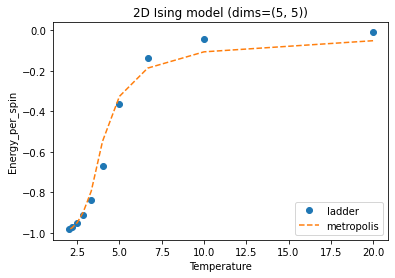

In [208]:
plt.plot(temp_list, mean_sampling_list, 'o', label='ladder')
plt.plot(temp_list, energy_metropolis_list, '--', label='metropolis')
plt.xlabel('Temperature')
plt.ylabel('Energy_per_spin')
plt.title('2D Ising model (dims=(5, 5))')
plt.legend()